# 💰 User Spending Categorization with Clustering (Aggregated Data)

## Objective
Categorize users into 5 distinct spending profiles using K-Means clustering.
We will rank the clusters by financial health to ensure distinct categorization:
1. **Super Saver** (Best Savings Rate)
2. **Smart Saver**
3. **Balanced**
4. **Big Spender**
5. **Wild Spender** (Worst Savings Rate)

## Dataset
Using `data.csv` which contains aggregated user profiles.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


In [2]:
# Load data
df = pd.read_csv('/content/sample_data/data.csv')

# Define expense columns to sum
expense_cols = [
    'Rent', 'Loan_Repayment', 'Insurance', 'Groceries', 'Transport',
    'Eating_Out', 'Entertainment', 'Utilities', 'Healthcare',
    'Education', 'Miscellaneous'
]

# Calculate Feature: Total Expenses
df['total_expenses'] = df[expense_cols].sum(axis=1)

# Calculate Feature: Total Income (rename for clarity)
df['total_income'] = df['Income']

# Calculate Feature: Savings Rate
df['savings_rate'] = (df['total_income'] - df['total_expenses']) / df['total_income']
df['savings_rate'] = df['savings_rate'].clip(-2, 1)  # Clip extreme outliers

# Calculate Feature: Fixed vs Discretionary Ratio
fixed_costs = df['Rent'] + df['Loan_Repayment'] + df['Insurance'] + df['Utilities'] + df['Education']
discretionary_costs = df['Eating_Out'] + df['Entertainment'] + df['Miscellaneous'] + df['Groceries'] + df['Transport']

df['fixed_cost_ratio'] = fixed_costs / df['total_expenses']
df['discretionary_cost_ratio'] = discretionary_costs / df['total_expenses']

# Clean data
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['savings_rate', 'total_expenses'])

print(f"Processed data shape: {df.shape}")
df[['total_income', 'total_expenses', 'savings_rate']].describe()

Processed data shape: (20000, 32)


,total_income,total_expenses,savings_rate
count,2.000000e+04,20000.000000,20000.000000
mean,4.158550e+04,30938.128847,0.255122
std,4.001454e+04,30178.438857,0.097190
min,1.301187e+03,988.427114,-0.062378
25%,1.760488e+04,12874.895453,0.189708
50%,3.018538e+04,22258.035933,0.264887
75%,5.176545e+04,38342.848276,0.327676
max,1.079728e+06,702668.155036,0.506504


## Clustering with K-Means

In [3]:
# Select features for clustering
feature_cols = [
    'total_income',
    'total_expenses',
    'savings_rate',
    'fixed_cost_ratio',
    'discretionary_cost_ratio'
]

X = df[feature_cols].copy()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

print("Cluster distribution:")
print(df['cluster'].value_counts().sort_index())

Cluster distribution:
cluster
0    6866
1    6379
2     259
3    4266
4    2230
Name: count, dtype: int64


## Distinct Label Assignment

We calculate the average `savings_rate` for each cluster and rank them.
- Rank 1 (Highest Savings Rate) -> Super Saver
- ...
- Rank 5 (Lowest Savings Rate) -> Wild Spender

This guarantees every category is used.

In [4]:
# Analyze cluster profiles
cluster_profiles = df.groupby('cluster')[feature_cols].mean()

# Sort clusters by Savings Rate in Descending Order (Best to Worst)
sorted_clusters = cluster_profiles.sort_values('savings_rate', ascending=False)

# Define Categories in order of rank
categories_ranked = [
    'Super Saver',
    'Smart Saver',
    'Balanced',
    'Big Spender',
    'Wild Spender'
]

# Create Mapping: Cluster ID -> Category Name
cluster_labels = {}
for rank, (cluster_id, row) in enumerate(sorted_clusters.iterrows()):
    cluster_labels[cluster_id] = categories_ranked[rank]

print("Cluster Mapping (Ranked by Savings Rate):")
for cid, label in cluster_labels.items():
    rate = sorted_clusters.loc[cid, 'savings_rate']
    print(f"Cluster {cid}: {label:<15} (Avg Savings: {rate:.1%})")

# Apply to dataframe
df['category'] = df['cluster'].map(cluster_labels)
print("\nFinal Category Distribution:")
print(df['category'].value_counts())

Cluster Mapping (Ranked by Savings Rate):
Cluster 3: Super Saver     (Avg Savings: 36.5%)
Cluster 0: Smart Saver     (Avg Savings: 28.3%)
Cluster 4: Balanced        (Avg Savings: 24.9%)
Cluster 2: Big Spender     (Avg Savings: 23.3%)
Cluster 1: Wild Spender    (Avg Savings: 15.5%)

Final Category Distribution:
category
Smart Saver     6866
Wild Spender    6379
Super Saver     4266
Balanced        2230
Big Spender      259
Name: count, dtype: int64


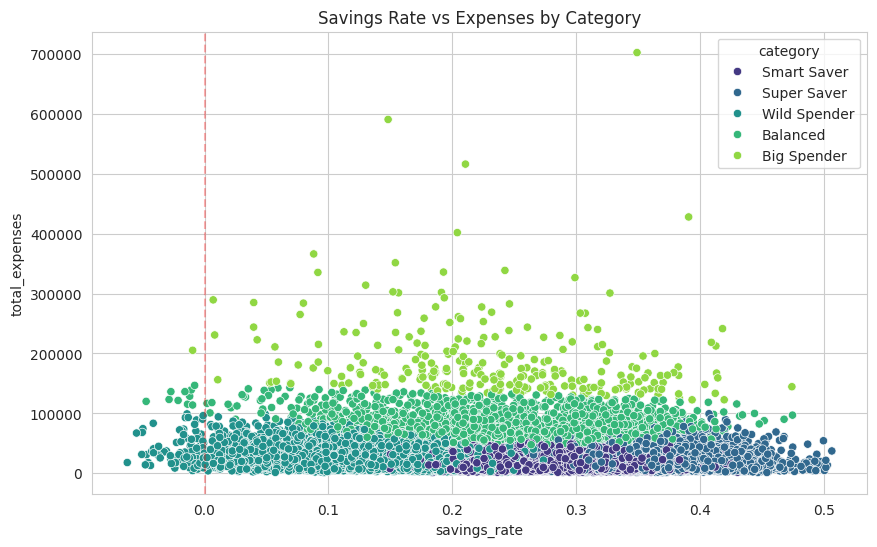

In [5]:
# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='savings_rate', y='total_expenses', hue='category', palette='viridis')
plt.title('Savings Rate vs Expenses by Category')
plt.axvline(0, color='red', linestyle='--', alpha=0.3)
plt.show()

In [9]:
# Save the Model
model_data = {
    'kmeans': kmeans,
    'scaler': scaler,
    'feature_cols': feature_cols,
    'cluster_labels': cluster_labels,  # This now contains the dynamic mapping
    'cluster_profiles': cluster_profiles
}

with open('../user_category_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("✓ Model successfully saved with distinct categories!")

✓ Model successfully saved with distinct categories!
